In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import re
from nltk.corpus import stopwords
import nltk
import numpy as np
from sklearn.model_selection import learning_curve
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import LabelEncoder

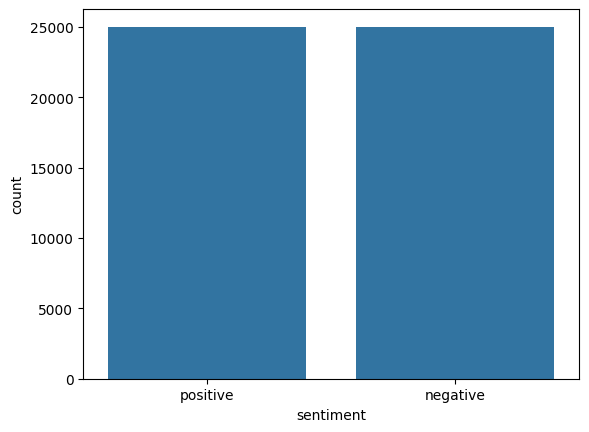

In [2]:
df = pd.read_csv("IMDB_Dataset.csv")
# checking if dataset is balanced
sns.countplot(x="sentiment", data=df)
plt.show()

In [3]:
# preprocessing

df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment'],
    test_size=0.2, # 80 percent training and 20 percent testing
    random_state=42, 
    stratify=df['sentiment']   #to keep balance in training and testing dataset
)
# TF-IDF without cleaning
vectorizer_raw = TfidfVectorizer(max_features=5000, stop_words='english') # removing common words like 'the', 'is', etc . top 5000 words are usually enough for sentiment analysis, especially with a large dataset like IMDB dataset
X_train_raw = vectorizer_raw.fit_transform(X_train) #learns vocabulary
X_test_raw = vectorizer_raw.transform(X_test) # does not learn vocabulary 


In [4]:
# Logistic Regression
lr_raw = LogisticRegression(max_iter=500) # changed max iterations from default so we can ensure weights are optimised 
lr_raw.fit(X_train_raw, y_train) # train model on our  training data
y_pred_raw = lr_raw.predict(X_test_raw) # predict on our testing data

In [5]:
print("Raw Reviews Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_raw))
print("Precision:", precision_score(y_test, y_pred_raw))
print("Recall:", recall_score(y_test, y_pred_raw))
print("F1 Score:", f1_score(y_test, y_pred_raw))
#recall refers to out of all the positive reviews, how many did we correctly identify as positive.
#precision refers to out of all the reviews we identified as positive, how many were actually positive.
# F1 score is the mean of precision and recall.

Raw Reviews Performance:
Accuracy: 0.8899
Precision: 0.8838354006694231
Recall: 0.8978
F1 Score: 0.8907629725171148


In [6]:
#cleaned dataset
nltk.download('stopwords') #here, 'stopwords' are words like 'the', 'is', 'in', etc. (note that we already used something like this in the TF IDF vectorizer above.)
#we use NLTK to clean the text data.
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()                                # lowercase
    text = re.sub(r"<.*?>", " ", text)                 # remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text)             # keep only letters
    text = re.sub(r"\s+", " ", text).strip()           # remove extra spaces
    text = " ".join([w for w in text.split() if w not in stop_words])  # remove stopwords
    return text

df['clean_review'] = df['review'].apply(clean_text)
X_train_clean, X_test_clean, y_train, y_test = train_test_split(
    df['clean_review'], df['sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
) # same as before but using cleaned reviews

# TF-IDF with cleaning
vectorizer_clean = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_clean = vectorizer_clean.fit_transform(X_train_clean)
X_test_clean = vectorizer_clean.transform(X_test_clean)

# Logistic Regression
lr_clean = LogisticRegression(max_iter=500)
lr_clean.fit(X_train_clean, y_train)
y_pred_clean = lr_clean.predict(X_test_clean)

print("Cleaned Reviews Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_clean))
print("Precision:", precision_score(y_test, y_pred_clean))
print("Recall:", recall_score(y_test, y_pred_clean))
print("F1 Score:", f1_score(y_test, y_pred_clean))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\final\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaned Reviews Performance:
Accuracy: 0.8907
Precision: 0.8837163622078177
Recall: 0.8998
F1 Score: 0.8916856604895451


In [7]:
results = {
    "Model": ["Logistic Regression (Raw)", "Logistic Regression (Cleaned)"],
    "Accuracy": [accuracy_score(y_test, y_pred_raw), accuracy_score(y_test, y_pred_clean)],
    "Precision": [precision_score(y_test, y_pred_raw), precision_score(y_test, y_pred_clean)],
    "Recall": [recall_score(y_test, y_pred_raw), recall_score(y_test, y_pred_clean)],
    "F1": [f1_score(y_test, y_pred_raw), f1_score(y_test, y_pred_clean)],
}
accuracylr=accuracy_score(y_test, y_pred_raw)
precisionlr=precision_score(y_test, y_pred_raw)
recalllr=recall_score(y_test, y_pred_raw)
f1lr=f1_score(y_test, y_pred_raw)
accuracylrc=accuracy_score(y_test, y_pred_clean)
precisionlrc=precision_score(y_test, y_pred_clean)
recalllrc=recall_score(y_test, y_pred_clean)
f1lrc=f1_score(y_test, y_pred_clean)

results_df = pd.DataFrame(results)
print(results_df) # cleaning slightly improves accuracy and precision

                           Model  Accuracy  Precision  Recall        F1
0      Logistic Regression (Raw)    0.8899   0.883835  0.8978  0.890763
1  Logistic Regression (Cleaned)    0.8907   0.883716  0.8998  0.891686


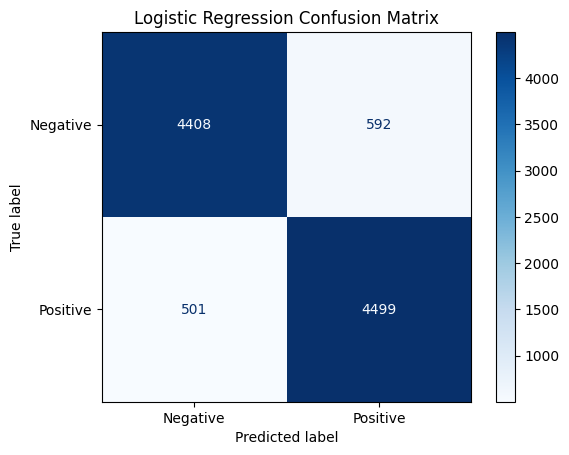

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
# will be explained in detail in readme
disp = ConfusionMatrixDisplay.from_estimator(
    lr_clean, X_test_clean, y_test,
    display_labels=["Negative", "Positive"],
    cmap=plt.cm.Blues,
    normalize=None  
)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [ ]:
# will be explained in readme
train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=500),
    X_train_clean, y_train, 
    cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=1
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation accuracy')
plt.title("Learning Curve - Logistic Regression")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

SyntaxError: keyword argument repeated: n_jobs (1017804184.py, line 6)

In [ ]:
## pytorch RNN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import re



d:\Projects\imdbdataset\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# let's make the data clean, preparing it for tokenisation. ( we can use the previously used clean text function used in the scikitlearn model)
df = pd.read_csv("IMDB_Dataset.csv")
df['clean_review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'positive':1, 'negative':0})
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)


In [ ]:
# TOKENISATION
# essentially splitting text into words so we can process them numerically.
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  
#for example
review = "the new demon slayer movie was incredible!"
encoded = tokenizer(
    review,
    padding='max_length',  # pad to max_length
    truncation=True,       # truncate if too long
    max_length=20,         # max tokens
    return_tensors='pt'    # return PyTorch tensors
)
print(encoded)
#explaining the output: we see three tensors, namely input ids, token type ids and attention mask.
#input ids are the token ids for each word in the sentence.
#token type ids are used to differentiate between different sentence pairs like question + answer. ( 0 for first sentence, 1 for second). since its single sentence, all are 0.
#attention mask tells us which tokens are actual words (1) and which are padding (0).

{'input_ids': tensor([[  101,  1996,  2047,  5698, 20005,  3185,  2001,  9788,   999,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [ ]:
#creating our custom dataset with tokens
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_length=256):
        self.reviews = reviews.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length ## labels to list, reviews to list, tokenizer
    def __len__(self):
        return len(self.reviews) # return no. of reviews
    def __getitem__(self, idx):
        review = str(self.reviews[idx]) # access one item of dataset
        label = self.labels[idx]
        encoding = self.tokenizer( 
            review,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt' #same as above encoder
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),  # remove extra dimension using squeeze, rest are same output as discussed in bert tokenizer above
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long) 
        }

In [ ]:
#for training, we need to feed our custom data set in batches, along with shuffling so the model does not learn the data order. also, as we will see in the training loop later, we can iterate over these batches efficiently.
maxlen = 256 # if a review is longer than maxlen, we cut it off, or else pad it to reach maxlen.
batch_size = 32 # balancing training speed and memory usage 

train_dataset = IMDBDataset(X_train, y_train, tokenizer, maxlen)
test_dataset = IMDBDataset(X_test, y_test, tokenizer, maxlen)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
#RNN MODEL
# we will use LSTM (Long Short Term Memory) which is a type of RNN , controls what to remember and what to forget, good for sentiment analysis (better than regular rnn)
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, output_dim, pad_idx, dropout=0.3):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)  # dropout after embeddings
        self.rnn = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0  # LSTM layer dropout
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.dropout(x)  # apply dropout after embedding
        x = x * attention_mask.unsqueeze(2).float()  # mask padding
        
        output, (hidden, cell) = self.rnn(x)
        out = self.fc(hidden[-1])  # take last layer hidden state
        return out.squeeze()

In [ ]:
#instantiation of the model: paremeters
vocab_size = tokenizer.vocab_size
embed_dim = 200
hidden_dim = 256
num_layers = 2
output_dim = 1
pad_idx = tokenizer.pad_token_id
dropout = 0.0  

In [ ]:
model = SentimentRNN(vocab_size, embed_dim, hidden_dim, num_layers, output_dim, pad_idx, dropout)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
## init model, loss function and optimizer

Epoch 1: Train Loss=0.1831, Val Loss=0.4279, Val Acc=0.8605
Epoch 2: Train Loss=0.1228, Val Loss=0.4321, Val Acc=0.8625
Epoch 3: Train Loss=0.0701, Val Loss=0.5204, Val Acc=0.8656
Early stopping triggered!
Accuracy: 0.8656
Precision: 0.8841950399327448
Recall: 0.8414
F1 Score: 0.8622668579626973


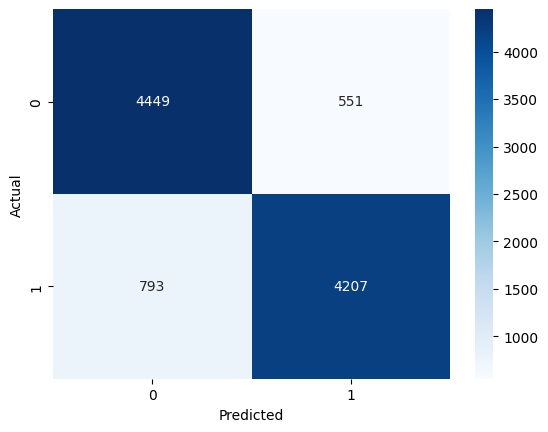

In [ ]:
num_epochs = 6
patience = 2  # number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    # TRAINING 
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    #  VALIDATION 
    model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:  
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels.float())
            total_val_loss += loss.item()

            preds = (outputs >= 0.5).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(test_loader)
    val_acc = accuracy_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}")

    # EARLY STOPPING 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt') 
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# Metrics
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Precision:", precision_score(all_labels, all_preds))
print("Recall:", recall_score(all_labels, all_preds))
print("F1 Score:", f1_score(all_labels, all_preds))
accuracypytorch=accuracy_score(all_labels, all_preds)
precisionpytorch=precision_score(all_labels, all_preds)
recallpytorch=recall_score(all_labels, all_preds)
f1pytorch=f1_score(all_labels, all_preds)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
## Linear SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

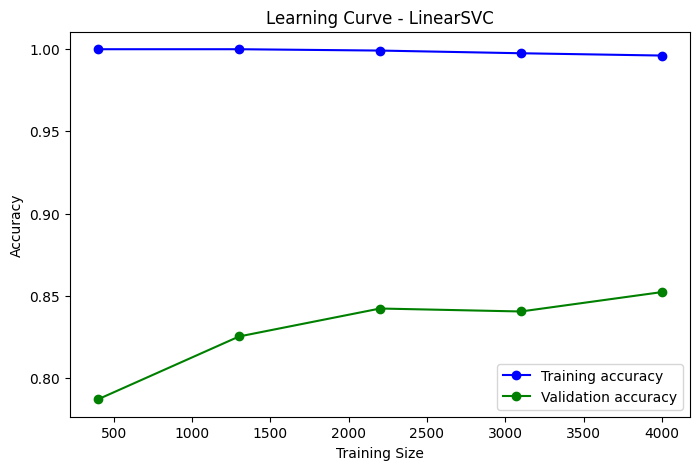

Accuracy: 0.8802
Precision: 0.8748028391167192
Recall: 0.8874
F1 Score: 0.881056393963463


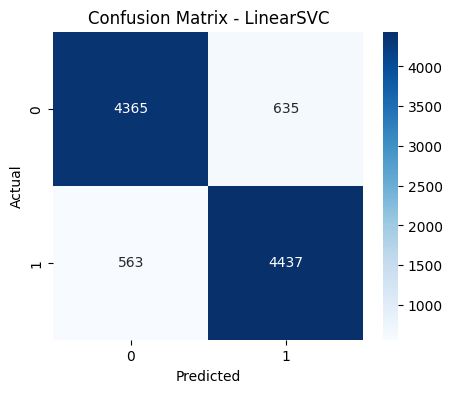

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.svm import LinearSVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Optional: Use a smaller subset to reduce memory load
subset_size = 5000  # adjust if needed
X_train_subset = X_train_clean[:subset_size]
y_train_subset = y_train[:subset_size]


svm = LinearSVC(random_state=42, max_iter=5000)

train_sizes, train_scores, test_scores = learning_curve(
    svm,
    X_train_subset,
    y_train_subset,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=1  
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation accuracy')
plt.title("Learning Curve - LinearSVC")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


svm.fit(X_train_clean, y_train)
y_pred_svm = svm.predict(X_test_clean)


accuracysvc = accuracy_score(y_test, y_pred_svm)
precisionsvc = precision_score(y_test, y_pred_svm)
recallsvc = recall_score(y_test, y_pred_svm)
f1svc = f1_score(y_test, y_pred_svm)

print("Accuracy:", accuracysvc)
print("Precision:", precisionsvc)
print("Recall:", recallsvc)
print("F1 Score:", f1svc)

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - LinearSVC")
plt.show()



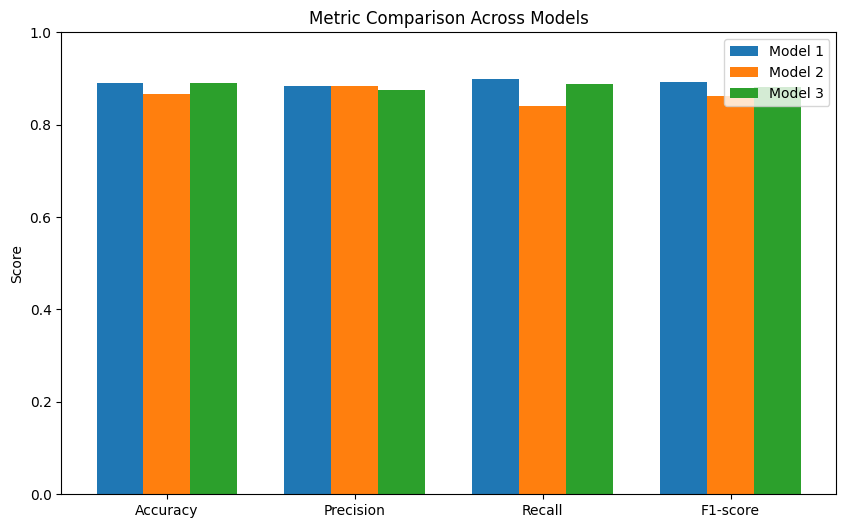

In [ ]:
metrics_dict = {
    "Model 1": [accuracylrc, precisionlrc, recalllrc, f1lrc],
    "Model 2": [accuracypytorch, precisionpytorch, recallpytorch, f1pytorch],
    "Model 3": [accuracysvc, precisionsvc, recallsvc, f1svc],
}
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
n_metrics = len(metrics)
n_models = len(metrics_dict)

x = np.arange(n_metrics)  
width = 0.25  

plt.figure(figsize=(10,6))

# Plot each model's metrics
for i, (model_name, vals) in enumerate(metrics_dict.items()):
    plt.bar(x + (i - n_models/2 + 0.5)*width, vals, width=width, label=model_name)

plt.xticks(x, metrics)
plt.ylim(0,1)
plt.ylabel('Score')
plt.title('Metric Comparison Across Models')
plt.legend()
plt.show()

In [ ]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# lr = LogisticRegression(max_iter=500)
# svc = LinearSVC(max_iter=5000)
# ensemble = VotingClassifier(
#     estimators=[('lr', lr), ('svc', svc)],
#     voting='hard'  
# )
# ensemble.fit(X_train_clean, y_train)
# y_pred_ensemble = ensemble.predict(X_test_clean)
# accuracyensemble = accuracy_score(y_test, y_pred_ensemble)
# precisionensemble = precision_score(y_test, y_pred_ensemble)
# recallensemble = recall_score(y_test, y_pred_ensemble)
# f1ensemble = f1_score(y_test, y_pred_ensemble)
# print("Ensemble Accuracy:", accuracyensemble)
# print("Ensemble Precision:", precisionensemble)
# print("Ensemble Recall:", recallensemble)
# print("Ensemble F1 Score:", f1ensemble)
# cm = confusion_matrix(y_test, y_pred_ensemble)
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title("Confusion Matrix - Ensemble")
# plt.show()
# metrics_dict = {
#     'LogisticRegression': [accuracylr, precisionlr, recalllr, f1lr],
#     'LinearSVC': [accuracysvc, precisionsvc, recallsvc, f1svc],
#     'Ensemble': [accuracyensemble, precisionensemble, recallensemble, f1ensemble]
# }
# metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
# x = np.arange(len(metrics_names))
# width = 0.25
# plt.figure(figsize=(8,5))
# plt.bar(x - width, metrics_dict['LogisticRegression'], width, label='LR')
# plt.bar(x, metrics_dict['LinearSVC'], width, label='SVC')
# plt.bar(x + width, metrics_dict['Ensemble'], width, label='Ensemble')
# plt.xticks(x, metrics_names)
# plt.ylabel("Score")
# plt.title("Model Comparison")
# plt.ylim(0, 1)
# plt.legend()
# plt.show()
